# Imports

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
from typing import Tuple, Dict, Any, List, Union, Optional, Callable


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from metrics import calculate_metrics

random_state = 42


# Introduction

TODO: Write something here!

# Notations

TODO: Maybe write something here!

# Environment

TODO: Write something here!

# Dataset

We'll be using the [Loan-Approval-Prediction-Dataset](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?resource=download) dataset from kaggle.

The loan approval dataset is a collection of financial records and associated information used to determine the eligibility of individuals or organizations for obtaining loans from a lending institution. It includes various factors such as:
1. cibil score: The customer's credit card score. 
2. income: The customer's income.
3. employment status: If the customer is self employed or not.
4. loan term: The duration for which the loan is taken, expressed in years. 
5. loan amount.
6. Residential/Commercial/Bank/Luxury assets value
7. loan status: If the loan is approved or not!

Before diving in, we'll explore the dataset to make it easier for the reader to get an overall intuition.

In [167]:
# Load the dataset
input_dir = "./kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv"
loan_original = pd.read_csv(input_dir)

loan_original.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


As we can see, there are strings in the data. We'll transform the dataset so we can apply learning algorithms on it.

In [168]:
# columns have weird spaces in names:
loan_original.columns = loan_original.columns.str.replace(" ", "")
loan_original[loan_original["loan_id"].duplicated(keep=False) == True].sort_values(
    ["loan_id"]
)
# remove the loan_id column
loan_ds = loan_original.drop(["loan_id"], axis=1)

# replace all spaces in loan_status and education and self_employed columns to ""
loan_ds["loan_status"] = loan_ds["loan_status"].str.replace(" ", "")
loan_ds["education"] = loan_ds["education"].str.replace(" ", "")
loan_ds["self_employed"] = loan_ds["self_employed"].str.replace(" ", "")

GRADUATE_STRING = loan_ds["education"].unique()[0]
NOT_GRADUATE_STRING = loan_ds["education"].unique()[1]
# make education column binary
loan_ds["education"] = loan_ds["education"].apply(
    lambda x: 1 if x == GRADUATE_STRING else 0
)

APPROVED_STRING = loan_ds["loan_status"].unique()[0]
REJECTED_STRING = loan_ds["loan_status"].unique()[1]
# make loan_status column binary
loan_ds["loan_status"] = loan_ds["loan_status"].apply(
    lambda x: 1 if x == APPROVED_STRING else 0
)

YES_STRING = loan_ds["self_employed"].unique()[1]
NO_STRING = loan_ds["self_employed"].unique()[0]
# make self_employed column binary
loan_ds["self_employed"] = loan_ds["self_employed"].apply(
    lambda x: 1 if x == YES_STRING else 0
)

loan_ds.describe(include="all")

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,0.502225,0.503631,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,0.500054,0.500045,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,0.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,0.000000,0.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,1.000000,1.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,1.000000,1.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,1.000000,1.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


By the data cleaning scans, we have confirmed:

1. There is no null value and duplicated value in this dataset.
2. `no_of_dependents`, `education`, `self_employed` and `loan_status` are categorical columns.
3. There are a total 4269 rows in this dataset, with 13 columns (features).
4. There are 2656 data with an approved `loan_status`, which is about 62.2% compared to the "rejected" group. The dataset is slightly imbalanced but it is acceptable and we don't need to rebalance it.
5. Other columns are numerical.

## Dataset Explorations and Features Relations

We'll also show the correlation matrix as it's always useful to do so.

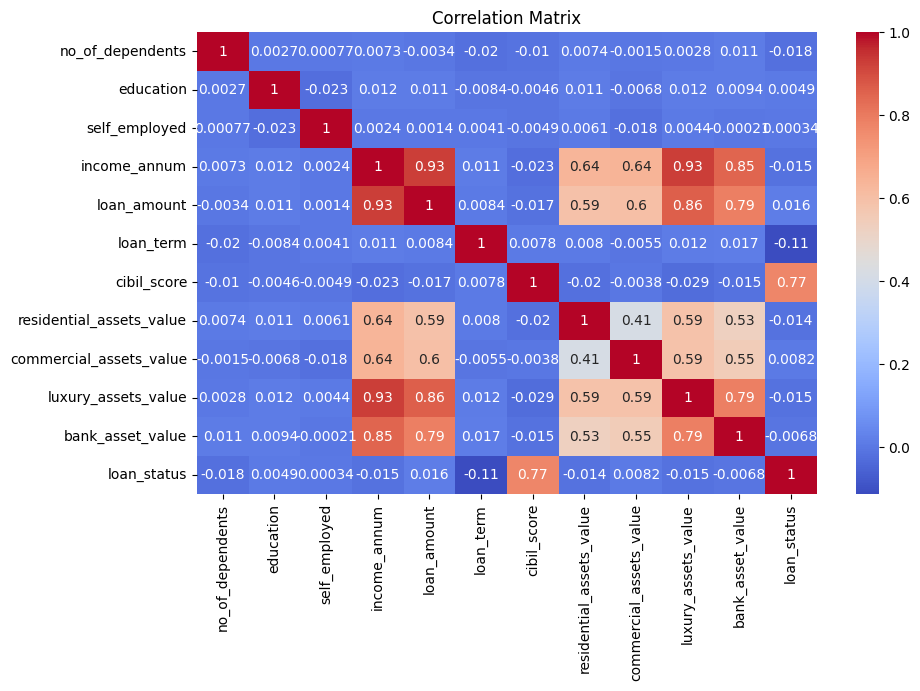

In [169]:
# corr and sns.heatmap
corr = loan_ds.corr()
plt.figure(figsize=(10, 6))

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

We'll try and see if there're some "important" features that directly affect the loan_status (Approved/Rejected).

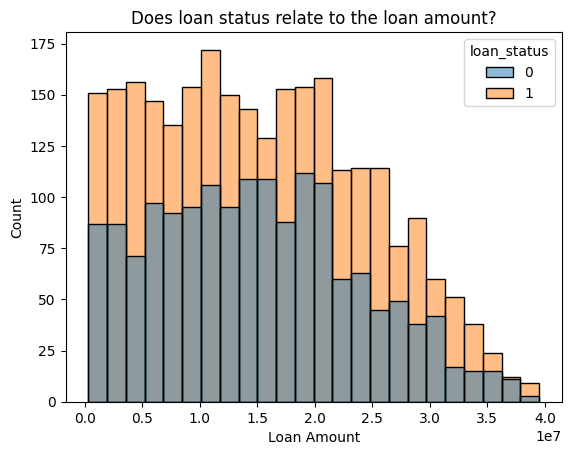

In [170]:
sns.histplot(loan_ds, x="loan_amount", hue="loan_status")
plt.title("Does loan status relate to the loan amount?")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

We can see that loan amount does not affect the loan status.

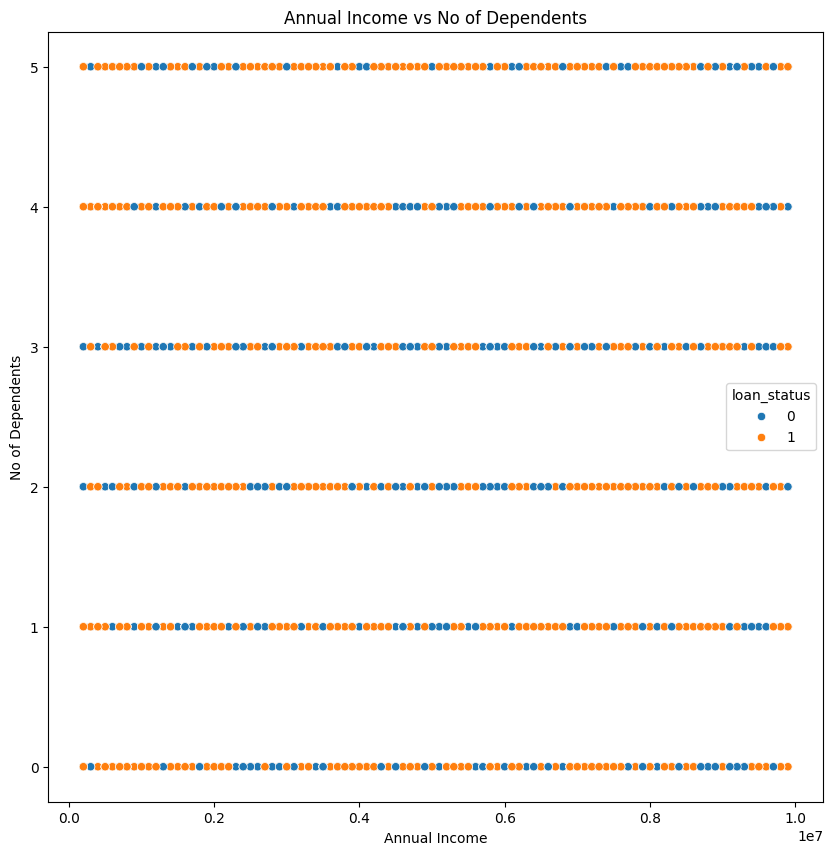

In [171]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=loan_ds, x="income_annum", y="no_of_dependents", hue="loan_status")
plt.title("Annual Income vs No of Dependents")
plt.xlabel("Annual Income")
plt.ylabel("No of Dependents")
plt.show()

We can see that num of dependents and annual income are not very effective in predicting loan status.

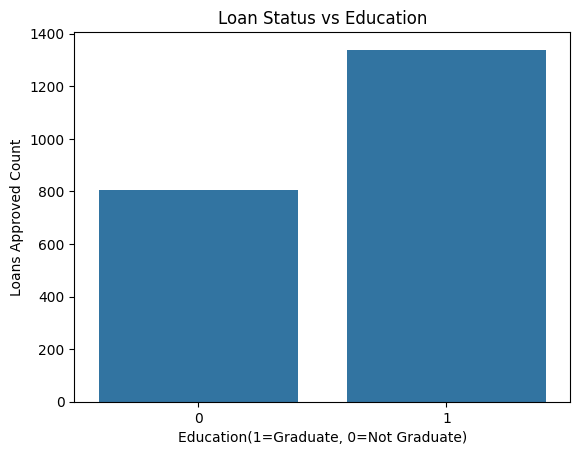

In [172]:
sns.countplot(data=loan_ds[loan_ds["education"] == 1], x="loan_status")
plt.title("Loan Status vs Education")
plt.xlabel("Education(1=Graduate, 0=Not Graduate)")
plt.ylabel("Loans Approved Count")
plt.show()

We can see the binary "Education" feature is somewhat informative to predict loan status.

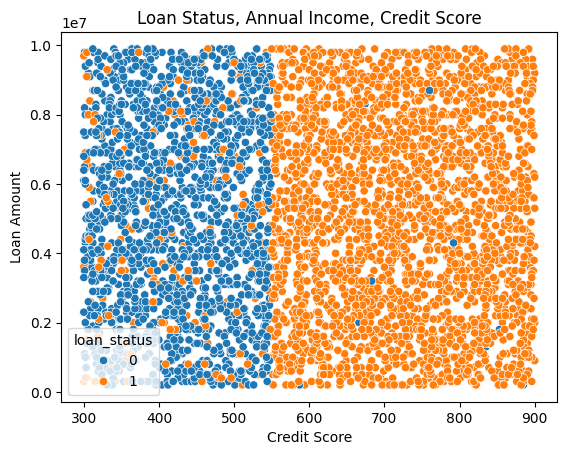

In [173]:
sns.scatterplot(
    x=loan_ds["cibil_score"], y=loan_ds["income_annum"], hue=loan_ds["loan_status"]
)
plt.title("Loan Status, Annual Income, Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

As can be seen, it seems that the data is kind of separable in terms of Credit Score as it appears there's some threshold. Let's try and implement a naiive model that classifies the data according to this threshold.

In [174]:
def acc_for_column_threshold(
    df,
    feature_column,
    threshold,
    target_column,
    target_value_below_thresh,
    target_value_above_thresh,
):
    df_thresh = df.copy()
    # remove all cols except feature_column and target_column
    df_thresh = df_thresh[[feature_column, target_column]]
    # create new column with thresholded values
    df_thresh["thresh_pred"] = df_thresh[feature_column] >= threshold
    # change True/False to target values
    df_thresh["thresh_pred"] = df_thresh["thresh_pred"].replace(
        {True: target_value_above_thresh, False: target_value_below_thresh}
    )
    # calculate accuracy
    acc = accuracy_score(df_thresh[target_column], df_thresh["thresh_pred"])
    return df_thresh, acc

In [175]:
threshold = 540
df_thresh, acc = acc_for_column_threshold(
    loan_ds, "cibil_score", threshold, "loan_status", 0, 1
)
print(f"Accuracy for cibil_score threshold {threshold}: ", acc)

Accuracy for cibil_score threshold 540:  0.9355821035371281


We see that we get 0.93 accuracy, which is impressive since as we've mentioned the data is not in imbalanced. If the data is imbalanaced say, 90% of loans are approved, a stupied classifier that always says 'Yes' would get 90% accuracy. But this is not our case.

## Training Different Models

TODO (Priel): Add explanation here about the models.

In [176]:
# Basic parameters
default_batch_size = 64
default_test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Splitting the dataset into features and target
X = loan_ds.drop("loan_status", axis=1).values
y = loan_ds["loan_status"].values

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=default_test_size, random_state=random_state
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [177]:
class MLPModel(nn.Module):
    def __init__(self, input_size, layers_sizes):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer_size in enumerate(layers_sizes):
            if i == 0:
                self.layers.append(nn.Linear(input_size, layer_size))
            else:
                self.layers.append(nn.Linear(layers_sizes[i - 1], layer_size))
            self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.Linear(layers_sizes[-1], 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)


class Conv1DModel(nn.Module):
    def __init__(self, input_size, output_channels=16, kernel_size=3):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(
            1, output_channels, kernel_size=kernel_size, padding=1)
        self.fc1 = nn.Linear(
            output_channels * ((input_size + 2 * 1 - kernel_size) // 1 + 1), 64
        )
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Assuming x has shape (batch_size, input_size), we need to unsqueeze to (batch_size, 1, input_size) for Conv1D
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [178]:
# Helper functions to create a PyTorch dataset and dataloader
def prepare_data(
    loan_ds,
    test_size=default_test_size,
    random_state=random_state,
    batch_size=default_batch_size,
):
    # Splitting the dataset into features and target
    X = loan_ds.drop("loan_status", axis=1).values
    y = loan_ds["loan_status"].values

    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Converting to PyTorch tensors
    X_torch_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_torch_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    y_torch_train = torch.tensor(y_train, dtype=torch.float32)
    y_torch_test = torch.tensor(y_test, dtype=torch.float32)

    # Creating datasets and dataloaders
    train_dataset = TensorDataset(X_torch_train_scaled, y_torch_train)
    test_dataset = TensorDataset(X_torch_test_scaled, y_torch_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader

# Helper function that gets the names of the models and their corresponding PyTorch models
def get_names_to_new_models(input_size):
    return {
        "Small MLP": MLPModel(input_size, [32, 16]),
        "Medium MLP": MLPModel(input_size, [64, 32, 16]),
        "Large MLP": MLPModel(input_size, [128, 64, 32, 16]),
        "Conv1D": Conv1DModel(input_size),  # Conv1D model
    }

# Helper function that trains and evaluates a PyTorch model
def train_and_evaluate_pytorch_model(
    threshold, model, model_name, train_loader, test_loader, epochs=100, lr=0.001
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training loop
    model.train()
    for epoch in tqdm.tqdm(range(epochs), desc=f"Training {model_name}"):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    metrics = calculate_metrics(all_labels, all_outputs, threshold)

    return {
        "model": model,
        "model_name": model_name,
        "metrics": metrics,
    }

# Helper function that compares the results of different models
# According to the metrics given in metrics parameter
def compare_torch_models(model_results, metrics):  
    model_metrics = []
    model_names = []
    for metric in metrics:
        model_metrics = [result["metrics"][metric] for result in model_results]
        model_names = [result["model_name"] for result in model_results]

    # Plotting
    x = np.arange(len(model_names))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(2, 1, figsize=(14, 12))

    for i, metric in enumerate(metrics):
        rects = ax[i].bar(x, model_metrics, width, label=metric, color="orange")
        # Show the number on the bars
        for rect in rects:
            height = rect.get_height()
            ax[i].annotate(
                f"{height:.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )
        ax[i].set_ylabel("Scores")
        ax[i].set_title(f"Model {metric} Comparison")
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(model_names)
        ax[i].legend()

    fig.tight_layout()
    plt.show()

Get the results of the different models using the helper functions above.

In [179]:
X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = prepare_data(loan_ds)
input_size = X_torch_train_scaled.shape[1]
names_to_models = get_names_to_new_models(input_size)
threshold = 0.5

torch_models_results = []
for model_name, model in names_to_models.items():
    model = model.to(device)
    result = train_and_evaluate_pytorch_model(
        threshold, model, model_name, train_loader, test_loader
    )
    torch_models_results.append(result)

Training Conv1D: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Compare the different torch models in terms of accuracy and f1_score.

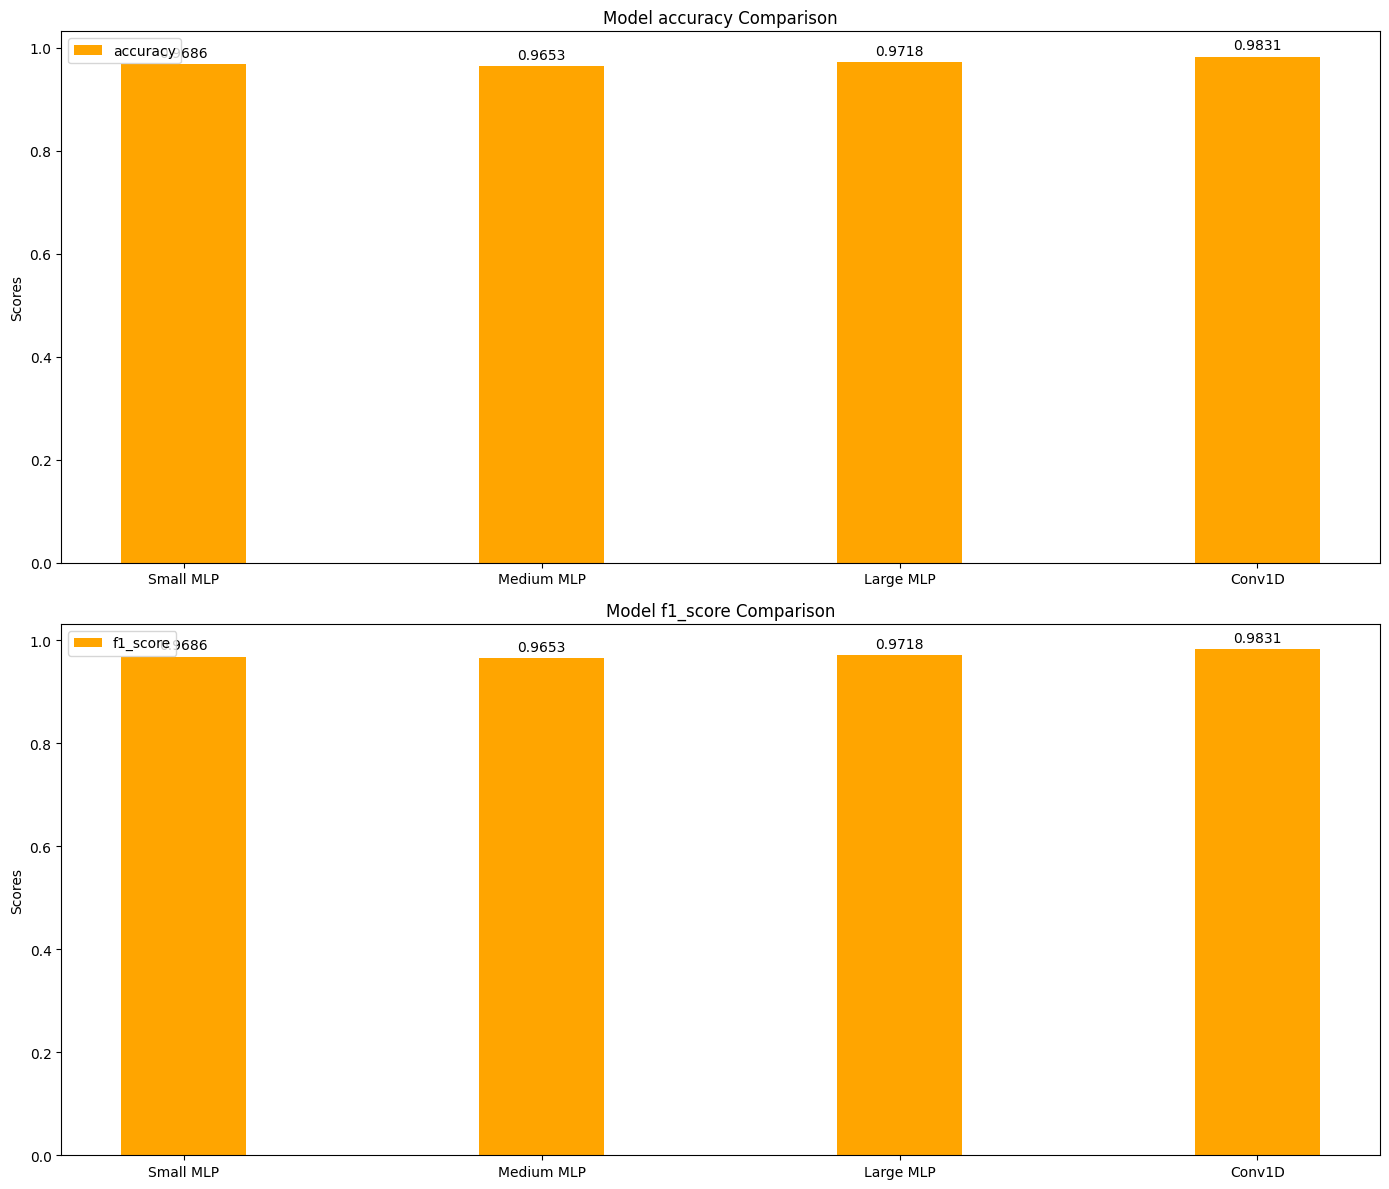

In [180]:
compare_torch_models(torch_models_results, ["accuracy", "f1_score"])

TODO (Thomas): Fix numbers on bars

It's evident that all models get very good results. LET THE CHALLENGE BEGIN!

# Gradients

TODO: Review what's written here!
In this section, we'll add the ability for users to perform strategies and see how the models get worse in time.

In [181]:
# Helper function that takes: model, loan_ds, row_index
# Calculates the gradient magnitude of the row in row_index in the dataset
def calculate_gradient_magnitude(model, loan_ds, row_index):
    row = loan_ds.iloc[row_index].copy()
    X = row.drop("loan_status").values
    X = scaler.transform(X.reshape(1, -1))
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y_pred = model(X).item()
    X.requires_grad = True
    y_pred = model(X)
    y_pred.backward()
    grads = X.grad.cpu().numpy().flatten()
    return grads, row

def calculate_and_plot_gradients(
    model, model_name, loan_ds, plot_first_num=5, metrics=None, plot_mean=True
):
    """
    Calculates gradients for each row in the dataset, plots the gradient magnitudes
    for the first 'plot_first_num' rows, and finally plots the mean gradient magnitude.
    Args:
    - model: The neural network model to use.
    - model_name: The name of the model.
    - loan_ds: The dataset.
    - plot_first_num: Number of initial gradients to plot individually.
    - metrics: The metrics dictionary for the model, if None we will not show it.
    - plot_mean: Whether to plot the mean gradient magnitude.

    Returns:
    - mean_grads: Vector of mean gradients across all features.
    """
    loan_ds_copy = loan_ds.copy()
    features = loan_ds_copy.iloc[0].drop("loan_status").index

    # calc acc, f1, mcc, roc_auc of the model
    X = loan_ds_copy.drop("loan_status", axis=1)
    y = loan_ds_copy["loan_status"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=default_test_size, random_state=random_state
    )

    # Initialize variables
    rows_to_calc_grad = loan_ds_copy.index
    all_grads = []

    # Calculate gradients for each row
    for loop_index, row_to_calc_grad in enumerate(rows_to_calc_grad):
        grads, row = calculate_gradient_magnitude(model, loan_ds_copy, row_to_calc_grad)
        all_grads.append(grads)

        # Plot for the first 'plot_first_num' rows
        if loop_index < plot_first_num:
            # print(f"Row: {row_to_calc_grad} with features:\n {row}")
            print(f"And Grads: {grads}")
            print("\n=================================\n")
            plt.figure(figsize=(10, 6))
            sns.barplot(x=grads, y=features, palette="viridis")
            plt.xlabel("Gradient Abs values")
            plt.ylabel("Feature")
            plt.title(
                f"Feature Importance for model {model_name} by Gradient, of row: {row_to_calc_grad}"
            )
            plt.show()

    # Calculate mean of all gradients
    mean_grads = np.mean(all_grads, axis=0)

    if plot_mean:
        # Plot mean gradients
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=mean_grads, y=features, palette="viridis")
        plt.xlabel("Gradient Mean values")
        plt.ylabel("Feature")
        title = f"Feature Importance by Gradient *Mean* for model: {model_name}"
        if metrics is not None:
            title += " | Metrics: \n"
            for key, value in metrics.items():
                if np.isscalar(value):
                    title += f"{key}: {value:.2f}, "
                else:
                    # makes image huge...
                    # title += f"{key}: {value}, "
                    pass
        print(f"title is: {title}")
        plt.title(title)

        # Customize plot appearance
        ax.set_facecolor("#303030")  # Dark grey background
        plt.gcf().set_facecolor("#303030")  # Set figure background color
        ax.xaxis.label.set_color("white")
        ax.yaxis.label.set_color("white")
        ax.title.set_color("white")
        ax.tick_params(axis="x", colors="white")
        ax.tick_params(axis="y", colors="white")
        ax.grid(axis="x")
        for spine in ax.spines.values():
            spine.set_edgecolor("white")
        plt.show()

    return mean_grads

title is: Feature Importance by Gradient *Mean* for model: Small MLP | Metrics: 
threshold_used: 0.50, auc: 0.99, accuracy: 0.96, f1_score: 0.97, mcc: 0.91, 


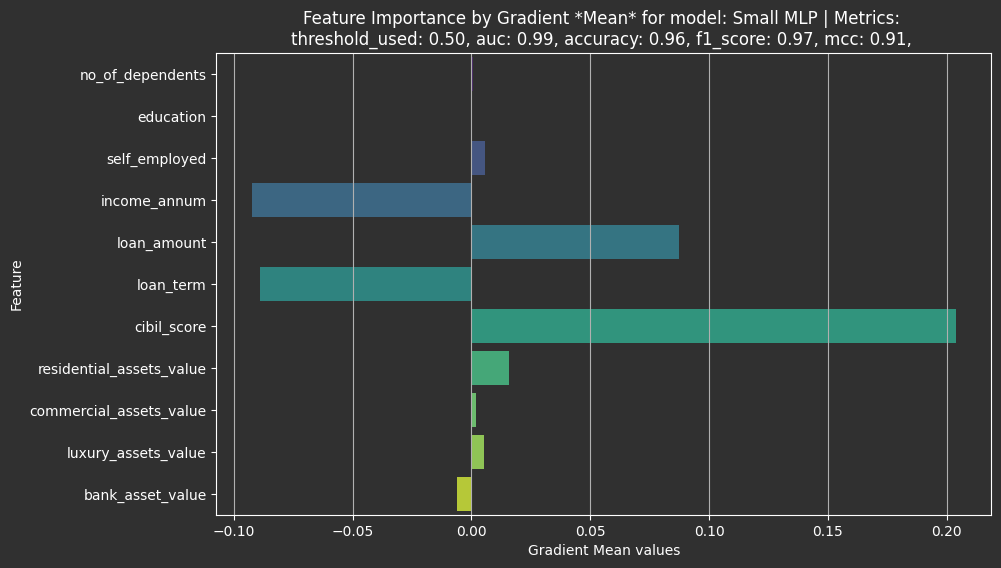

{'model': MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
), 'model_name': 'Small MLP', 'metrics': {'threshold_used': 0.5, 'auc': 0.9948136675114991, 'accuracy': 0.9601873536299765, 'f1_score': 0.9685767097966729, 'confusion_matrix': array([[296,  22],
       [ 12, 524]]), 'mcc': 0.9145670028927955, 'classification_report': {'0': {'precision': 0.961038961038961, 'recall': 0.9308176100628931, 'f1-score': 0.9456869009584664, 'support': 318.0}, '1': {'precision': 0.9597069597069597, 'recall': 0.9776119402985075, 'f1-score': 0.9685767097966729, 'support': 536.0}, 'accuracy': 0.9601873536299765, 'macro avg': {'precision': 0.9603729603729604, 'recall': 0.9542147751807003, 'f1-score': 0.9571318053775697, 'support': 854.0}, 'weighted avg': {'precision': 0.9602029508352693,

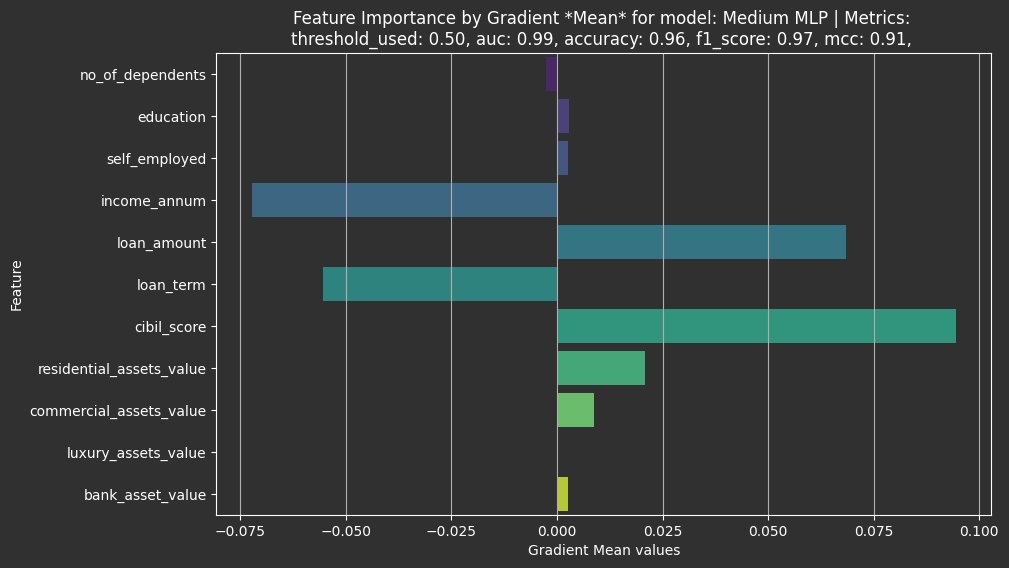

{'model': MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
), 'model_name': 'Medium MLP', 'metrics': {'threshold_used': 0.5, 'auc': 0.9923378391063551, 'accuracy': 0.9566744730679156, 'f1_score': 0.9652582159624413, 'confusion_matrix': array([[303,  15],
       [ 22, 514]]), 'mcc': 0.9078604106094489, 'classification_report': {'0': {'precision': 0.9323076923076923, 'recall': 0.9528301886792453, 'f1-score': 0.942457231726283, 'support': 318.0}, '1': {'precision': 0.9716446124763705, 'recall': 0.9589552238805971, 'f1-score': 0.9652582159624413, 'support': 536.0}, 'accuracy': 0.9566744730679156, 'macro avg': {'precision': 0.9519761523920314, 'recall': 0.9558927062799212, 'f1-score':

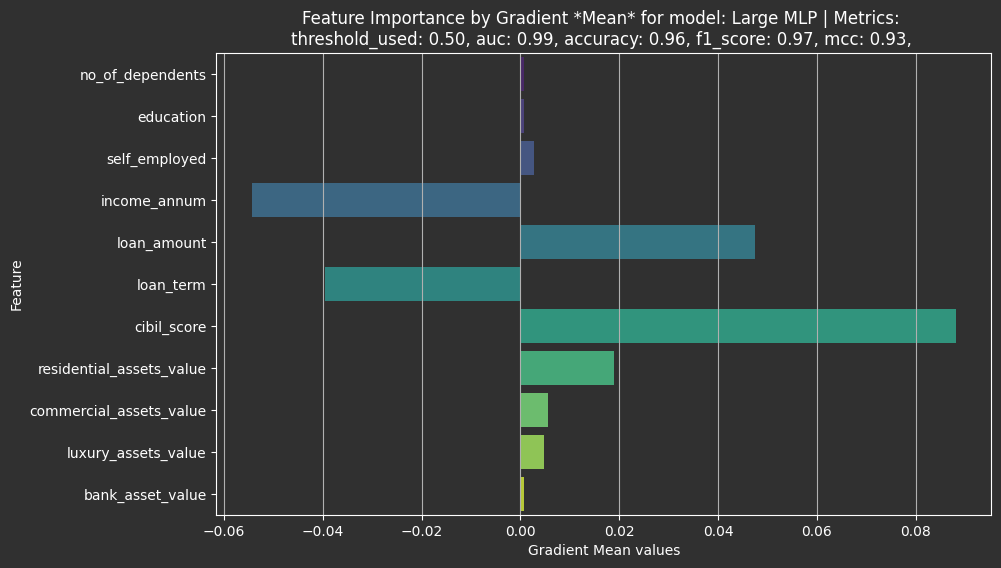

{'model': MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
), 'model_name': 'Large MLP', 'metrics': {'threshold_used': 0.5, 'auc': 0.9946552614287054, 'accuracy': 0.9648711943793911, 'f1_score': 0.9717514124293786, 'confusion_matrix': array([[308,  10],
       [ 20, 516]]), 'mcc': 0.9256094829043992, 'classification_report': {'0': {'precision': 0.9390243902439024, 'recall': 0.9685534591194969, 'f1-score': 0.9535603715170279, 'support': 318.0}, '1': {'precision': 0.9809885931558935, 'recall': 0.9626865671641791, 'f1-score': 0.9717514124293786, 'support': 536.0}, 'accuracy': 0.9648711943793911

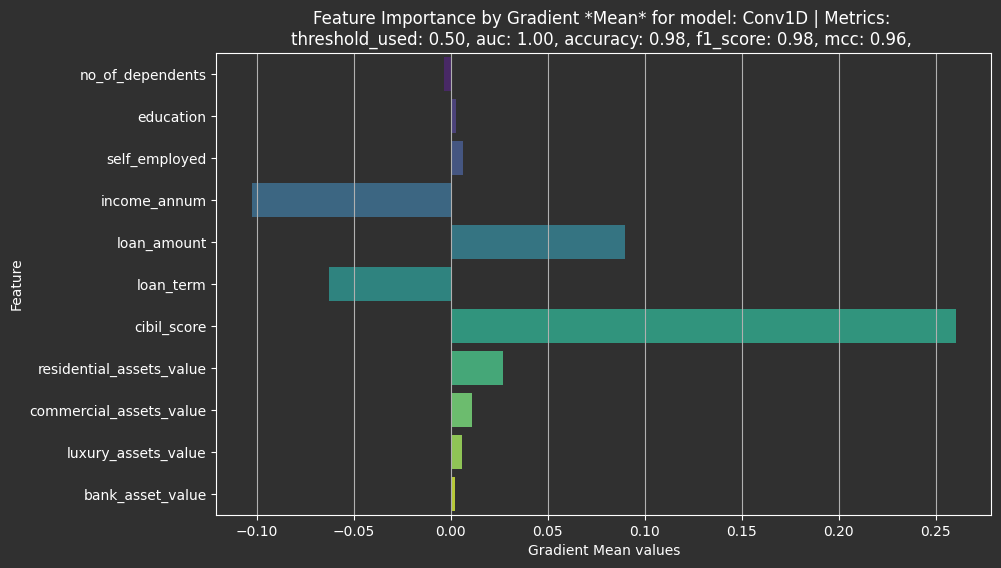

{'model': Conv1DModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=176, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
), 'model_name': 'Conv1D', 'metrics': {'threshold_used': 0.5, 'auc': 0.9984335398479302, 'accuracy': 0.9789227166276346, 'f1_score': 0.9830827067669173, 'confusion_matrix': array([[313,   5],
       [ 13, 523]]), 'mcc': 0.955326512582827, 'classification_report': {'0': {'precision': 0.9601226993865031, 'recall': 0.9842767295597484, 'f1-score': 0.9720496894409938, 'support': 318.0}, '1': {'precision': 0.990530303030303, 'recall': 0.9757462686567164, 'f1-score': 0.9830827067669173, 'support': 536.0}, 'accuracy': 0.9789227166276346, 'macro avg': {'precision': 0.975326501208403, 'recall': 0.9800114991082325, 'f1-score': 0.9775661981039556, 'support': 854.0}, 'weighted avg': {'precision': 0.9792075653737123, 'recall': 0.9789227166276346, 'f1-score': 0.9789743935237748, 'support': 8

In [185]:
for model_result in torch_models_results:
    model_name = model_result["model_name"]
    model = model_result["model"]
    metrics = model_result["metrics"]
    mean_grads = calculate_and_plot_gradients(
        model, model_name, loan_ds, plot_first_num=0, metrics=metrics
    )

As expected, the cibil_score is significantly informative across all models. The average gradient of the score with respect to this feature is very high, indicating that increasing the cibil_score aligns with the direction of the gradient, which in turn enhances the score.

Similarly, reducing the loan_term leads to a higher score, as the average gradient with respect to this feature is negative.

Additionally, as models increase in size, they begin to consider additional features. This is evidenced by the mean gradient vector becoming more balanced in terms of absolute values across different features, suggesting that larger models utilize a broader range of features.

This expansion in feature usage by larger models can be explained by their improved ability to discern the relationships between less informative features and the loan_status compared to smaller models, thereby incorporating these lower-information features into their assessments.

# Strategic Users

Now, as we've made ourselves familiar with the data and how important in average each feature is, we'll try and utilize this information to create an environment with strategic users.

In [186]:
def create_strategists_loan_ds(
    loan_ds_to_change: pd.DataFrame,
    range_strategists_act: Tuple[float, float],
    features_to_change: Dict[str, Tuple[Tuple[float, float], float]],
    model_to_fool: nn.Module,
):
    """
    Calculates gradients for each row in the dataset, plots the gradient magnitudes
    for the first 'plot_first_num' rows, and finally plots the mean gradient magnitude.
    Args:
    - loan_ds_to_change: loan dataset to change
    - range_strategists_act: The score range of which users are chosen to be strategic. i.e. (0.3, threshold) 
    - features_to_change: A dictionary of features to change, with a range to choose from and a the gradient itself
    - model_to_fool: The model to try and fool

    Returns:
    - strategists_loan_ds: loan dataset after performing strategies.
    - strategists_rows: The rows of users that performed strategy
    """
    strategists_loan_ds = loan_ds_to_change.copy()
    for index, row in strategists_loan_ds.iterrows():
        X = row.drop("loan_status").values
        X = scaler.transform(X.reshape(1, -1))
        X = torch.tensor(X, dtype=torch.float32).to(device)
        y_pred = model_to_fool(X).item()
        # add the y_pred as score column
        strategists_loan_ds.at[index, "score_before_strategy"] = y_pred
        if range_strategists_act[0] <= y_pred <= range_strategists_act[1]:
            # set the using_strategy column to True
            strategists_loan_ds.at[index, "using_strategy"] = True
            # TODO: Change info to be more informative
            for feature_name, info in features_to_change.items():
                value_to_add = np.random.uniform(
                    info[0][0], info[0][1]
                )
                gradient_sign = np.sign(info[1])
                strategists_loan_ds.at[index, feature_name] += (value_to_add * gradient_sign)
        else:
            # set the using_strategy column to False
            strategists_loan_ds.at[index, "using_strategy"] = False
    strategists_rows = strategists_loan_ds[
        strategists_loan_ds["using_strategy"] == True
    ]
    # Drop the unwanted columns
    strategists_loan_ds.drop(
        ["using_strategy", "score_before_strategy"], axis=1, inplace=True
    )
    return strategists_loan_ds, strategists_rows

Now, we'll utilize the above function to implement an initial dynamic simulation. The simulation would have T timestamps, starting with the initial loan dataset (loan_ds). At each timestamp, the process involves calculating the mean gradients of features, selecting the top feature K with the highest absolute mean gradients (as these have the most significant impact on the model), and recording these in a 'features_to_change' list. The selected features are then uniformly adjusted within the range of [feature current mean * 0.1, feature current mean * 0.2].


Timestamp 0:


Training Large MLP:   0%|          | 0/100 [00:00<?, ?it/s]

Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 25.45it/s]


title is: Feature Importance by Gradient *Mean* for model: Large MLP | Metrics: 
threshold_used: 0.50, auc: 0.99, accuracy: 0.95, f1_score: 0.96, mcc: 0.90, 


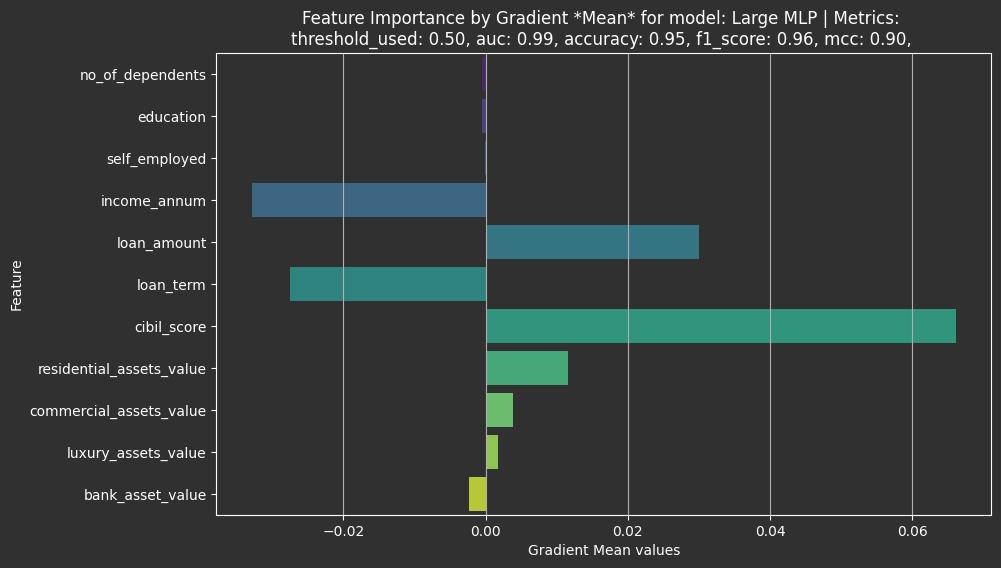

Top 1 features for model Large MLP: Index(['cibil_score'], dtype='object')
Features to change for model Large MLP: {'cibil_score': ((239.97442023893183, 299.96802529866477), 0.066188596)}
Model Large MLP created 1610 strategists.
title is: Feature Importance by Gradient *Mean* for model: Large MLP | Metrics: 
threshold_used: 0.50, auc: 0.99, accuracy: 0.95, f1_score: 0.96, mcc: 0.90, 


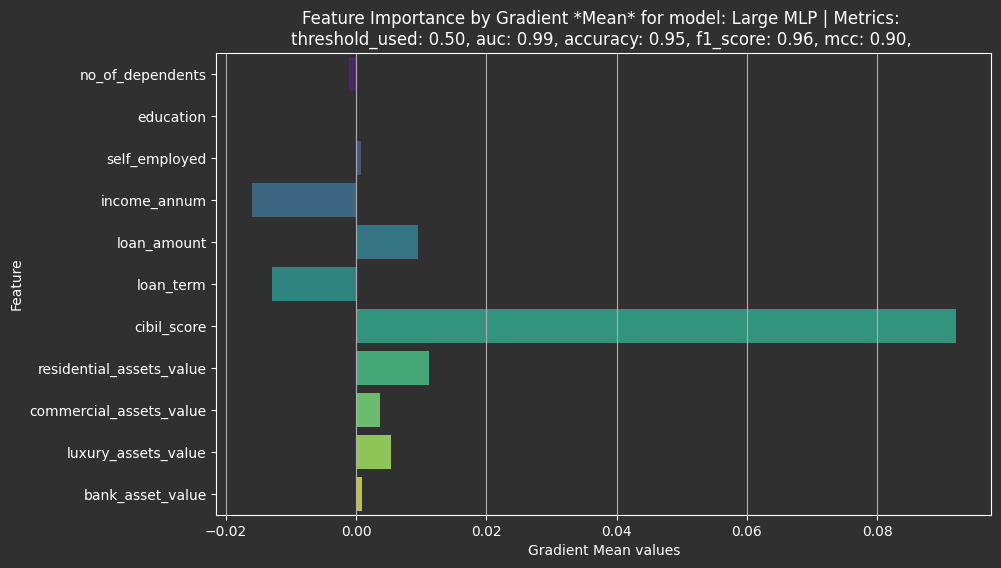

In [187]:
T = 1 # number of times to perform strategies
K = 1 # number of features to change (top k features in terms of mean gradient)
MODEL = "Large MLP" # model to use

strategists_loan_ds_dict = {}
strategists_rows_dict = {}
results_dict = {}
range_strategists_act = (threshold - 0.5, threshold)
feature_mean_ratio = 0.4
names_to_models = get_names_to_new_models(input_size)
for model_name, _ in names_to_models.items():
    strategists_loan_ds_dict[model_name] = loan_ds.copy()
    

for t in range(T):
    print(f"Timestamp {t}:")
    for model_name, model in names_to_models.items():
        if model_name != MODEL: # Get rid off this line to run on all models
            continue

        model = model.to(device)
        # Prepare the data
        X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = prepare_data(strategists_loan_ds_dict[model_name])
        # Train and evaluate
        results_dict[model_name] = train_and_evaluate_pytorch_model(
            threshold, model, model_name, train_loader, test_loader
        )
        metrics = results_dict[model_name]["metrics"]
        # calculate and plot gradients
        mean_grads = calculate_and_plot_gradients(
            model, model_name, strategists_loan_ds_dict[model_name], plot_first_num=0, metrics=metrics, plot_mean=True
        )

        # Get the top K features
        top_k_indices = np.argsort(np.abs(mean_grads))[::-1][:K]
        top_k_features = strategists_loan_ds_dict[model_name].columns[top_k_indices]
        print(f"Top {K} features for model {model_name}: {top_k_features}")

        # Create features_to_change dictionary
        features_to_change = {}
        for feature, index in zip(top_k_features, top_k_indices):
            mean_feature_value = strategists_loan_ds_dict[model_name][feature].mean()
            # features_to_change is a dictionary of feature: (range, gradient)
            features_to_change[feature] = ((mean_feature_value * feature_mean_ratio, mean_feature_value * (feature_mean_ratio + 0.1)), mean_grads[index])

        print(f"Features to change for model {model_name}: {features_to_change}")

        # Create strategists_loan_ds
        strategists_loan_ds_dict[model_name], strategists_rows_dict[model_name] = create_strategists_loan_ds(
            strategists_loan_ds_dict[model_name], range_strategists_act, features_to_change, model
        )

        print(f"Model {model_name} created {len(strategists_rows_dict[model_name])} strategists.")

# Show mean gradients for the models chosen
for model_result in results_dict.values():
    if model_result["model_name"] != MODEL:
        continue
    model_name = model_result["model_name"]
    model = model_result["model"]
    metrics = model_result["metrics"]
    calculate_and_plot_gradients(
        model, model_name, strategists_loan_ds_dict[model_name], plot_first_num=0, metrics=metrics
    )

We can clearly see that after 5 rounds of simulation, the importance of cibil_score dropped drastically. It even becamse the second most important feature. Notice also that the accuracy almost didn't get affected.

TODO: Needs more explanation

TODO: Run the simulation for 30+ timestamps. It would be interesting to observe what happens.